# Functional EDeN for RNA

Using functional coding style with the Explicit Decomposition with Neighborhoods vectorizer

`jupyter nbconvert rna/multiclass_RNA.ipynb --to slides --post serve`

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

/Users/costa/anaconda/envs/eden_env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/costa/anaconda/envs/eden_env/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from toolz import curry, compose, map, concat, pipe

In [3]:
import multiprocessing as mp
from eden import apply_async

def chunks(iterable, n):
    iterable = iter(iterable)
    while True:
        items = []
        try:
            for i in range(n):
                it = iterable.next()
                items.append(it)
        finally:
            if items:
                yield items

def degenerate(func, iterable):
    return list(func(iterable))

def parallelize(iterable, func=None, n_jobs=None, block_size=None):  
    dfunc = curry(degenerate)(func)
    items = []
    if n_jobs == 1:
        for item in func(iterable):
            items.append(item)
    if n_jobs == -1:
        pool = mp.Pool(mp.cpu_count())
    else:
        pool = mp.Pool(n_jobs)

    results = [apply_async(
        pool, dfunc,
        args=([subset_items]))
        for subset_items in chunks(iterable, block_size)]
    for i, p in enumerate(results):
        for item in p.get():
            items.append(item)
    pool.close()
    pool.join()
    return items

In [4]:
import multiprocessing as mp

num_fams = 9
num_seqs = 500
num_cpus = mp.cpu_count()
block_size = num_seqs / num_cpus

print 'Block size: %d   #CPUs: %d' % (block_size, num_cpus)

Block size: 62   #CPUs: 8


In [5]:
# import RNA sequences
from eden_rna.io.rfam import load
load_rfam = lambda num_seqs, rfam_id: load(rfam_id, seq_ids=range(num_seqs))
cload_rfam = curry(load_rfam)(num_seqs)

In [6]:
# map graphs to vectors
from eden.graph import vectorize
cvectorize = curry(vectorize)(complexity=3, nbits=16, n_jobs=num_cpus, block_size=block_size)

In [7]:
import random

def shuffle(sequence, times=None, order=None):
    header, seq = sequence
    for i in range(times):
        kmers = [seq[i:i + order] for i in range(0, len(seq), order)]
        random.shuffle(kmers)
        seq_out = ''.join(kmers)
        yield header, seq_out
        
cshuffle = curry(shuffle)(times=1, order=2)
make_negative = compose(concat, curry(map)(cshuffle))

In [8]:
import numpy as np
from scipy.sparse import vstack
from sklearn.linear_model import SGDClassifier

def make_data(cfold, rfam_ids):
    vec_fold_rfam_id = compose(cvectorize, cfold, cload_rfam)
    data_list = list(map(vec_fold_rfam_id, rfam_ids))
    class_X = vstack(data_list)
    class_y = list(concat([[i]*data.shape[0] 
                           for i, data in enumerate(data_list, start=1)]))

    neg_vec_fold_rfam_id = compose(cvectorize, cfold, make_negative,cload_rfam)
    neg_data_list = list(map(neg_vec_fold_rfam_id, rfam_ids))
    neg_X = vstack(neg_data_list)
    neg_y = list(concat([[0]*data.shape[0] for data in neg_data_list]))
    
    X = vstack((neg_X, class_X))
    y = np.array(neg_y + class_y)
    return X, y

In [9]:
from eden_rna.rnafold import fold
pfold = curry(parallelize)(func=fold, n_jobs=num_cpus, block_size=block_size)
cmake_data = curry(make_data)(pfold)

In [10]:
import numpy as np
from scipy.sparse import vstack
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

def predictive_performance(estimator, data):
    X, y = data
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    scoring = make_scorer(accuracy_score)
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    return scores

from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(average=True, class_weight='balanced', shuffle=True, n_jobs=num_cpus)
cpredictive_performance = curry(predictive_performance)(sgd)


def output_avg_and_std(scores):
    print('Acc: %.4f +- %.4f' % (np.mean(scores),np.std(scores)))

In [11]:
rfam_ids = ['RF00005','RF00004','RF00015','RF00020','RF00026','RF00169',
            'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
            'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
            'RF01942','RF01998','RF02005','RF02012','RF02034']
rfam_ids = rfam_ids[0:num_fams]

In [12]:
%%time
pipe(rfam_ids, cmake_data, cpredictive_performance, output_avg_and_std)

Acc: 0.9503 +- 0.0040
CPU times: user 3min 30s, sys: 11.7 s, total: 3min 42s
Wall time: 3min 43s


---

In [13]:
#fold sequence into a structure graph


# alternatives:
#sequence
from eden_rna.sequence import fold
cfold = fold

#RNAplfold
from eden_rna.rnaplfold import fold
plfold_params = dict(window_size = 250,
                     max_bp_span = 150,
                     hard_threshold=0.5,
                     avg_bp_prob_cutoff = 0.3,
                     max_num_edges = 2,
                     no_lonely_bps=True,
                     nesting=True)
cfold = curry(fold)(**plfold_params)

# RNAfold
from eden_rna.rnafold import fold
cfold = fold

In [14]:
def split(sequence, step=1, window=20):
    header, seq = sequence
    seq_len = len(seq)
    for start in range(0, seq_len, step):
        seq_out = seq[start: start + window]
        if len(seq_out) == window:
            end = int(start + len(seq_out))
            header_out = '%s_%d:%d' % (header, start, end)
            yield (header_out, seq_out)

csplit = curry(split)(step=10, window=30)
csplit_seqs = curry(map)(csplit)

from networkx import disjoint_union
union_redux = lambda graphs: reduce(disjoint_union, graphs, graphs.next())

def windowed_fold(cfold, seqs):
    for windows in csplit_seqs(seqs):
        graphs = cfold(windows)
        yield union_redux(graphs)

cwindowed_fold = curry(windowed_fold)(cfold)
p_fold = curry(parallelize)(func=cwindowed_fold, n_jobs=8, block_size=block_size)

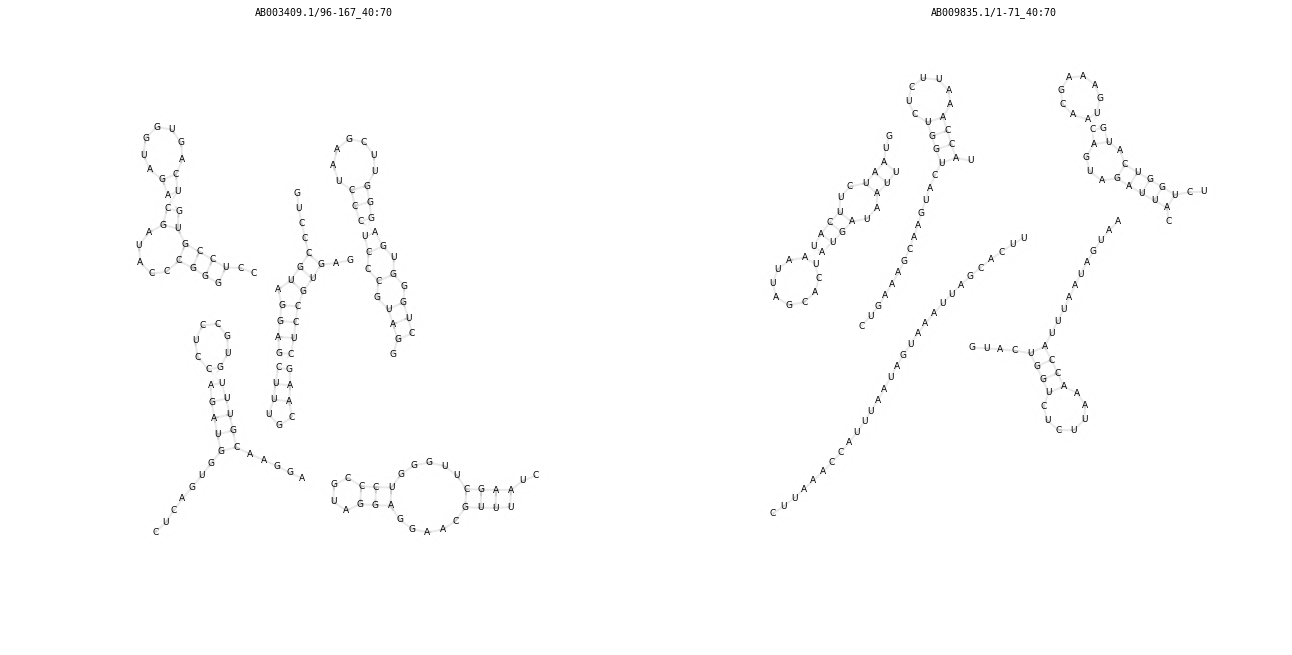

In [15]:
seqs = load_rfam(2, rfam_ids[0])
graphs = cwindowed_fold(seqs)

from eden.display import draw_graph_set
draw_graph_set(graphs, n_graphs_per_line=2, size=11)

---

In [16]:
cmake_data = curry(make_data)(p_fold)

In [17]:
%%time
pipe(rfam_ids, cmake_data, cpredictive_performance, output_avg_and_std)

Acc: 0.9502 +- 0.0055
CPU times: user 6min 30s, sys: 25.4 s, total: 6min 55s
Wall time: 9min 28s


In [18]:
from sklearn.model_selection import train_test_split
    
def train_and_test(estimator, data):
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    y_scores = estimator.decision_function(X_test)
    return y_test, y_pred, y_scores


from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(average=True, class_weight='balanced', shuffle=True, n_jobs=num_cpus)
ctrain_and_test = curry(train_and_test)(sgd)

In [19]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from eden.display import plot_confusion_matrices

def predicitve_performance_report(data):
    y_true, y_pred, y_scores = data
    
    line_size = 135
    print '_'*line_size
    print
    print 'Accuracy: %.3f' % accuracy_score(y_true, y_pred)
    
    y_true_bin = LabelBinarizer().fit_transform(y_true)
    print ' AUC ROC: %.3f' % roc_auc_score(y_true_bin, y_scores)
    
    print '  AUC AP: %.3f' % average_precision_score(y_true_bin, y_scores)

    print '_'*line_size
    print
    print 'Classification Report:'
    print classification_report(y_true, y_pred)
    
    print '_'*line_size
    print
    plot_confusion_matrices(y_true, y_pred, size=int(len(set(y_true))*1.5))

_______________________________________________________________________________________________________________________________________

Accuracy: 0.940
 AUC ROC: 0.995
  AUC AP: 0.986
_______________________________________________________________________________________________________________________________________

Classification Report:
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       661
          1       0.85      0.87      0.86       167
          2       0.98      0.95      0.97        64
          3       1.00      0.91      0.95        58
          4       0.96      0.94      0.95        50
          5       1.00      0.96      0.98        55
          6       0.94      0.95      0.94        79
          7       0.98      1.00      0.99        61
          8       1.00      0.98      0.99        46
          9       0.98      0.94      0.96        47

avg / total       0.94      0.94      0.94      1288

________________

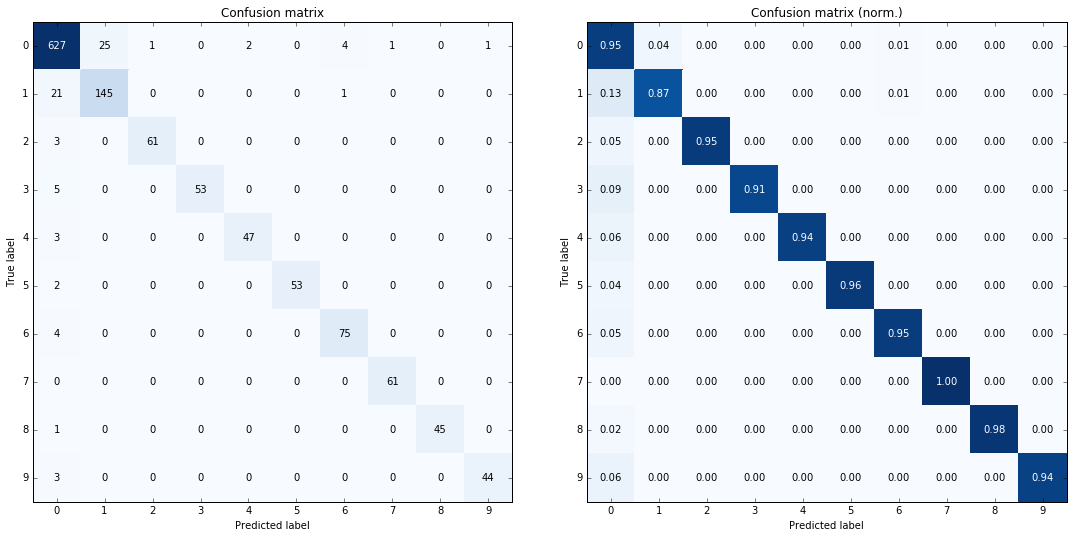

CPU times: user 2min 58s, sys: 22.9 s, total: 3min 20s
Wall time: 8min 55s


In [20]:
%%time
pipe(rfam_ids, cmake_data, ctrain_and_test, predicitve_performance_report)

---